In [ ]:
# my virtual environments are rarely properly connected to jupyter so this fixes that
import sys
import os
current_dir = os.getcwd()  # Get the current working directory
venv_dir = os.path.join(current_dir, 'venv') 
python_version = str(sys.version_info.major) + '.' + str(sys.version_info.minor)
site_packages_path = os.path.join(venv_dir, 'lib', 'python' + python_version, 'site-packages')
sys.path.append(site_packages_path) 

In [1]:
# Importing pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F

import numpy as np
import math

# imports for the debugging/demonstration setup
import functools
import inspect

import torch.utils.data
import matplotlib.pyplot as plt
from keras.datasets.mnist import load_data

import random
import time
from tqdm import tqdm

In [2]:
# this function will be used throughout for debugging/demonstration purposes
# using this is way cleaner than cluttering up our code with print statements
def log_io(func):
    @functools.wraps(func)
    def wrapper(self, *args, **kwargs):
        # Check if logging is enabled globally and for the specific function
        if not self.logging_enabled or func.__name__ in self.disabled_logging_functions:
            return func(self, *args, **kwargs)
        #if not self.logging_enabled:
            #return func(self, *args, **kwargs)

        def log_item(item, name, level=0, is_root=False):
            indent = "    " * level
            if isinstance(item, torch.Tensor):
                print(f"{indent}Tensor '{name}' shape: {item.shape}")
            elif isinstance(item, tuple):
                if is_root and level == 0:
                    # Root level tuple, don't print it as a tuple unless it's a "true" tuple
                    for idx, sub_item in enumerate(item):
                        log_item(sub_item, f"{name}[{idx}]", level)
                else:
                    print(f"{indent}Tuple '{name}':")
                    for idx, sub_item in enumerate(item):
                        log_item(sub_item, f"{name}[{idx}]", level + 1)
            elif isinstance(item, int):
                print(f"{indent}Integer '{name}': Value={item}")
            elif isinstance(item, float):
                print(f"{indent}Float '{name}': Value={item}")
            else:
                print(f"{indent}Other-type '{name}': Type={type(item).__name__}, Value={item}")

        print(f"\n{'='*10}Entering {self.__class__.__name__}.{func.__name__}{'='*10}")
        print("Inputs:")
        arg_names = inspect.getfullargspec(func).args[1:]  # Excluding 'self'
        arg_values = args + tuple(kwargs.values())
        for name, value in zip(arg_names, arg_values):
            log_item(value, name)

        result = func(self, *args, **kwargs)
        print("\nOutputs:")
        if isinstance(result, tuple):
            log_item(result, "output", is_root=True)
        else:
            log_item(result, "output")

        print(f"{'='*10}Exiting {self.__class__.__name__}.{func.__name__}{'='*10}")
        return result
    return wrapper

class LoggingModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.logging_enabled = False
        self.disabled_logging_functions = set()

    def enable_logging(self):
        self.logging_enabled = True

    def disable_logging(self):
        self.logging_enabled = False

    def disable_function_logging(self, func_name):
        self.disabled_logging_functions.add(func_name)

    def enable_function_logging(self, func_name):
        self.disabled_logging_functions.discard(func_name)

# Step-by-step walkthrough

from here on out the code is mostly from [here](https://github.com/MaximeVandegar/Papers-in-100-Lines-of-Code/tree/main/Denoising_Diffusion_Probabilistic_Models)

# UNet

I'm very fond of UNet. basically instead of a regular residual connection it has a huge amount of inter-connectedness in a kind of 'U' shape (sorta not really). Interestingly i've not yet been exposed to channel-wise attention in images so that's also kinda cool to see here. not fond of using torch.einsum just bc i'm not used to it but honestly it looks better than what i've been doing. it's so big tho i think for the full step-by-step guide i'm gonna have to not write out all of it

In [3]:
def get_timestep_embedding(timesteps, embedding_dim: int):
    """
    Retrieved from https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/nn.py#LL90C1-L109C13
    """
    assert len(timesteps.shape) == 1

    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=timesteps.device) * -emb)
    emb = timesteps.type(torch.float32)[:, None] * emb[None, :]
    emb = torch.concat([torch.sin(emb), torch.cos(emb)], axis=1)

    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.pad(emb, [[0, 0], [0, 1]])

    assert emb.shape == (timesteps.shape[0], embedding_dim), f"{emb.shape}"
    return emb


class Downsample(LoggingModule):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=2, padding=1)

    @log_io
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv(x)
        assert x.shape == (B, C, H // 2, W // 2)
        return x


class Upsample(LoggingModule):

    def __init__(self, C):
        """
        :param C (int): number of input and output channels
        """
        super(Upsample, self).__init__()
        self.conv = nn.Conv2d(C, C, 3, stride=1, padding=1)

    @log_io
    def forward(self, x):
        B, C, H, W = x.shape

        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='nearest')

        x = self.conv(x)
        assert x.shape == (B, C, H * 2, W * 2)
        return x


class Nin(LoggingModule):

    def __init__(self, in_dim, out_dim, scale=1e-10):
        super(Nin, self).__init__()

        n = (in_dim + out_dim) / 2
        limit = np.sqrt(3 * scale / n)
        self.W = torch.nn.Parameter(torch.zeros((in_dim, out_dim), dtype=torch.float32
                                                ).uniform_(-limit, limit))
        self.b = torch.nn.Parameter(torch.zeros((1, out_dim, 1, 1), dtype=torch.float32))

    @log_io
    def forward(self, x):
        return torch.einsum('bchw, co->bowh', x, self.W) + self.b


class ResNetBlock(LoggingModule):

    def __init__(self, in_ch, out_ch, dropout_rate=0.1):
        super(ResNetBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
        self.dense = nn.Linear(512, out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1)

        if not (in_ch == out_ch):
            self.nin = Nin(in_ch, out_ch)

        self.dropout_rate = dropout_rate
        self.nonlinearity = torch.nn.SiLU()

    @log_io
    def forward(self, x, temb):
        """
        :param x: (B, C, H, W)
        :param temb: (B, dim)
        """

        h = self.nonlinearity(nn.functional.group_norm(x, num_groups=32))
        h = self.conv1(h)

        # add in timestep embedding
        h += self.dense(self.nonlinearity(temb))[:, :, None, None]

        h = self.nonlinearity(nn.functional.group_norm(h, num_groups=32))
        h = nn.functional.dropout(h, p=self.dropout_rate)
        h = self.conv2(h)

        if not (x.shape[1] == h.shape[1]):
            x = self.nin(x)

        assert x.shape == h.shape
        return x + h


class AttentionBlock(LoggingModule):

    def __init__(self, ch):
        super(AttentionBlock, self).__init__()

        self.Q = Nin(ch, ch)
        self.K = Nin(ch, ch)
        self.V = Nin(ch, ch)

        self.ch = ch

        self.nin = Nin(ch, ch, scale=0.)

    @log_io
    def forward(self, x):
        B, C, H, W = x.shape
        assert C == self.ch

        h = nn.functional.group_norm(x, num_groups=32)
        q = self.Q(h)
        k = self.K(h)
        v = self.V(h)

        w = torch.einsum('bchw,bcHW->bhwHW', q, k) * (int(C) ** (-0.5))  # [B, H, W, H, W]
        w = torch.reshape(w, [B, H, W, H * W])
        w = torch.nn.functional.softmax(w, dim=-1)
        w = torch.reshape(w, [B, H, W, H, W])

        h = torch.einsum('bhwHW,bcHW->bchw', w, v)
        h = self.nin(h)

        assert h.shape == x.shape
        return x + h


class UNet(LoggingModule):

    def __init__(self, ch=128, in_ch=1):
        super(UNet, self).__init__()

        self.ch = ch
        self.linear1 = nn.Linear(ch, 4 * ch)
        self.linear2 = nn.Linear(4 * ch, 4 * ch)

        self.conv1 = nn.Conv2d(in_ch, ch, 3, stride=1, padding=1)

        self.down = nn.ModuleList([ResNetBlock(ch, 1 * ch),
                                   ResNetBlock(1 * ch, 1 * ch),
                                   Downsample(1 * ch),
                                   ResNetBlock(1 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   AttentionBlock(2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   Downsample(2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch),
                                   ResNetBlock(2 * ch, 2 * ch)])

        self.middle = nn.ModuleList([ResNetBlock(2 * ch, 2 * ch),
                                     AttentionBlock(2 * ch),
                                     ResNetBlock(2 * ch, 2 * ch)])

        self.up = nn.ModuleList([ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(4 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 ResNetBlock(3 * ch, 2 * ch),
                                 AttentionBlock(2 * ch),
                                 Upsample(2 * ch),
                                 ResNetBlock(3 * ch, ch),
                                 ResNetBlock(2 * ch, ch),
                                 ResNetBlock(2 * ch, ch)])

        self.final_conv = nn.Conv2d(ch, in_ch, 3, stride=1, padding=1)

    @log_io
    def forward(self, x, t):
        """
        :param x: (torch.Tensor) batch of images [B, C, H, W]
        :param t: (torch.Tensor) tensor of time steps (torch.long) [B]
        """

        temb = get_timestep_embedding(t, self.ch)
        temb = torch.nn.functional.silu(self.linear1(temb))
        temb = self.linear2(temb)
        assert temb.shape == (t.shape[0], self.ch * 4)

        x1 = self.conv1(x)

        # Down
        x2 = self.down[0](x1, temb)
        x3 = self.down[1](x2, temb)
        x4 = self.down[2](x3)
        x5 = self.down[3](x4, temb)
        x6 = self.down[4](x5)  # Attention
        x7 = self.down[5](x6, temb)
        x8 = self.down[6](x7)  # Attention
        x9 = self.down[7](x8)
        x10 = self.down[8](x9, temb)
        x11 = self.down[9](x10, temb)
        x12 = self.down[10](x11)
        x13 = self.down[11](x12, temb)
        x14 = self.down[12](x13, temb)

        # Middle
        x = self.middle[0](x14, temb)
        x = self.middle[1](x)
        x = self.middle[2](x, temb)

        # Up
        x = self.up[0](torch.cat((x, x14), dim=1), temb)
        x = self.up[1](torch.cat((x, x13), dim=1), temb)
        x = self.up[2](torch.cat((x, x12), dim=1), temb)
        x = self.up[3](x)
        x = self.up[4](torch.cat((x, x11), dim=1), temb)
        x = self.up[5](torch.cat((x, x10), dim=1), temb)
        x = self.up[6](torch.cat((x, x9), dim=1), temb)
        x = self.up[7](x)
        x = self.up[8](torch.cat((x, x8), dim=1), temb)
        x = self.up[9](x)
        x = self.up[10](torch.cat((x, x6), dim=1), temb)
        x = self.up[11](x)
        x = self.up[12](torch.cat((x, x4), dim=1), temb)
        x = self.up[13](x)
        x = self.up[14](x)
        x = self.up[15](torch.cat((x, x3), dim=1), temb)
        x = self.up[16](torch.cat((x, x2), dim=1), temb)
        x = self.up[17](torch.cat((x, x1), dim=1), temb)

        x = nn.functional.silu(nn.functional.group_norm(x, num_groups=32))
        x = self.final_conv(x)

        return x

# Data

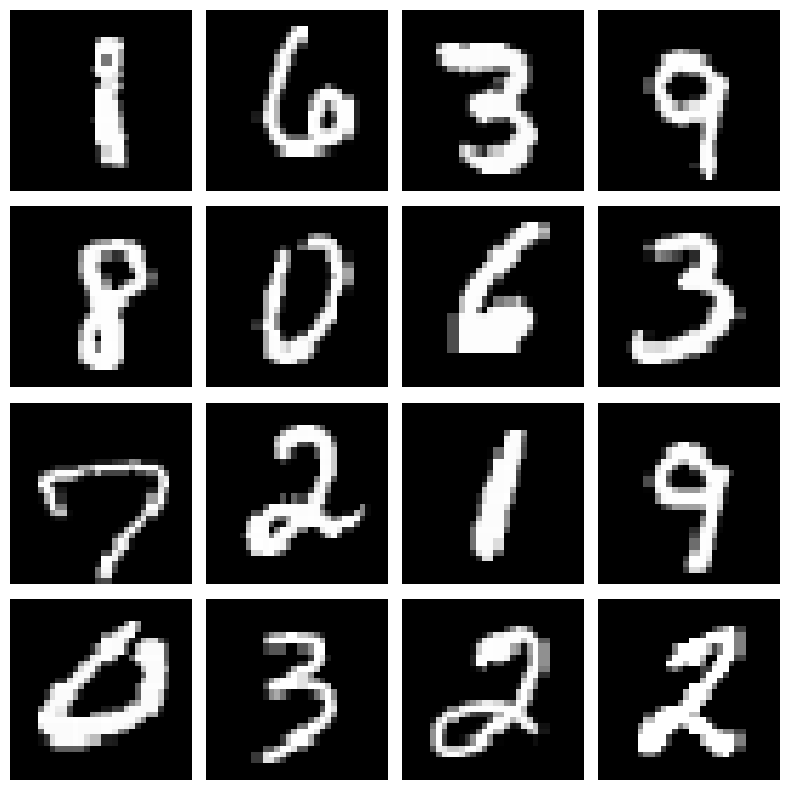

In [4]:
(trainX, trainy), (testX, testy) = load_data()
trainX = np.float32(trainX) / 255.
testX = np.float32(testX) / 255.


def sample_batch(batch_size, device):
    indices = torch.randperm(trainX.shape[0])[:batch_size]
    data = torch.from_numpy(trainX[indices]).unsqueeze(1).to(device)
    return torch.nn.functional.interpolate(data, 32)

def visualize_batch(batch, num_rows=4, num_cols=4, figsize=(8, 8)):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < batch.shape[0]:
            ax.imshow(batch[i, 0], cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Sample a batch of data
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch = sample_batch(batch_size, device)

# Visualize the batch
visualize_batch(batch.cpu().numpy())

# Diffusion Model

so basically we train a model to take data with signal and predict randomness. then during inference we input randomness, record of the difference between the inputted randomness and the outputted "more" randomness, thereby hopefully reverse-engineering us some signal, and keep doing that for every timestep while also adding in more randomness each timestep, and eventually that mean will grow into something interesting

In [5]:
class DiffusionModel:

    def __init__(self, T: int, model: nn.Module, device: str):
        self.T = T
        self.function_approximator = model.to(device)
        self.device = device

        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def training(self, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """

        x0 = sample_batch(batch_size, self.device)
        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device,
                          dtype=torch.long)
        eps = torch.randn_like(x0)

        # Take one gradient descent step
        alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(
            -1).unsqueeze(-1)
        eps_predicted = self.function_approximator(torch.sqrt(
            alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)
        loss = nn.functional.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=1, img_size=(32, 32),
                 use_tqdm=True):
        """
        Algorithm 2 in Denoising Diffusion Probabilistic Models
        """

        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)
        progress_bar = tqdm if use_tqdm else lambda x: x
        for t in progress_bar(range(self.T, 0, -1)):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z
        return x

# Training

In [8]:
device = 'cuda'
batch_size = 176
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, device)

# Training
for epoch in tqdm(range(1_000)):
    loss = diffusion_model.training(batch_size, optimizer)

100%|██████████| 1000/1000 [22:22<00:00,  1.34s/it]


# Inference

FileNotFoundError: [Errno 2] No such file or directory: 'Imgs/samples.png'

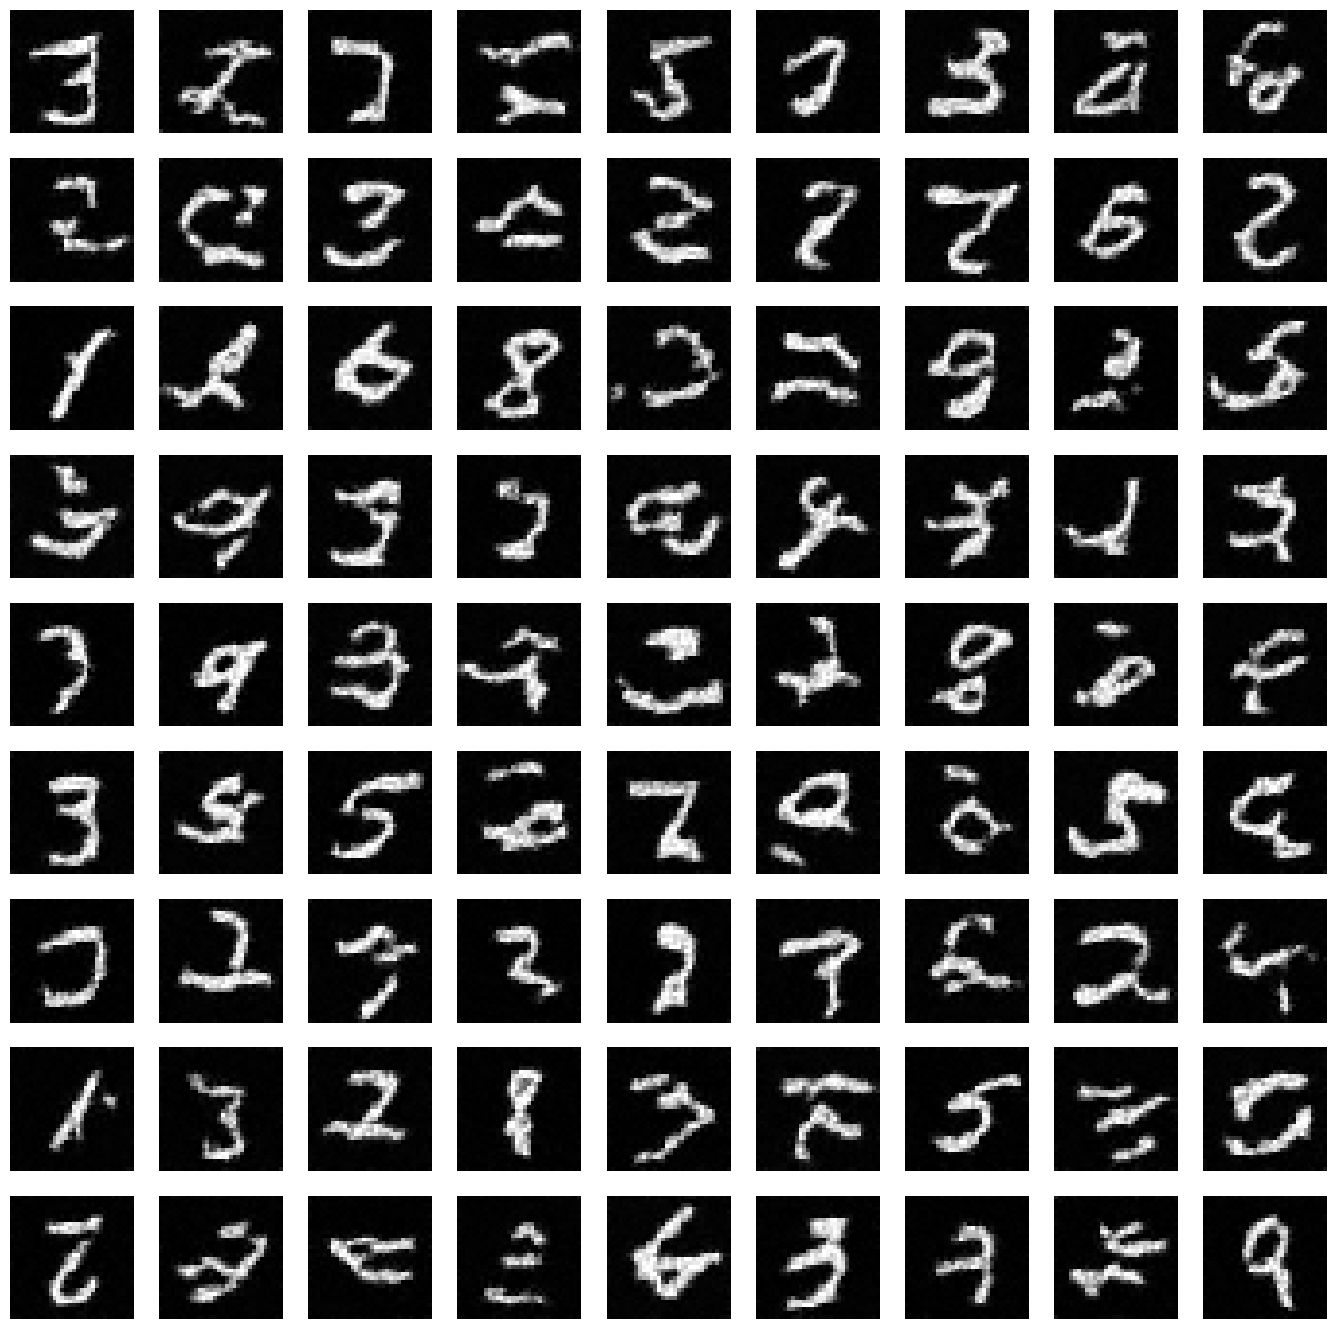

In [12]:
# Plot results
nb_images = 81
samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
plt.figure(figsize=(17, 17))
for i in range(nb_images):
    plt.subplot(9, 9, 1 + i)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(),cmap='gray')
plt.savefig(f'Imgs/samples.png')

In [11]:
device = 'cuda'
batch_size = 16
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
diffusion_model = DiffusionModel(1000, model, device)

# Training
for epoch in tqdm(range(10)):
    loss = diffusion_model.training(batch_size, optimizer)

100%|██████████| 10/10 [00:01<00:00,  5.80it/s]
